el dataset fue obtenido desde aqui "https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data".
El objetivo es ver si soy capaz de hacer forecast y predecir el valor del bitcoin.

In [2]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Cargamos el csv
train = pd.read_csv('btcusd_1-min_data.csv')

print(train.shape)

# Mostramos 10 registros al azar
train.sample(10)

(6750281, 6)


,Timestamp,Open,High,Low,Close,Volume
2372232,1.467760e+09,670.82,670.95,670.82,670.95,2.600000
71025,1.329674e+09,4.33,4.33,4.33,4.33,0.000000
3487913,1.534708e+09,6401.50,6401.87,6400.20,6400.20,1.000654
5537784,1.657715e+09,19724.50,19740.09,19706.98,19706.98,1.059418
2524659,1.476906e+09,626.29,626.56,626.23,626.23,13.919976
4969239,1.623599e+09,35829.64,35846.77,35825.91,35846.77,0.694784
4567416,1.599486e+09,10170.77,10172.04,10165.60,10171.18,2.874988
1270719,1.401662e+09,650.20,654.00,642.43,642.43,290.706183
1510263,1.416039e+09,393.41,393.41,393.41,393.41,0.000000
3429845,1.531224e+09,6616.74,6619.52,6616.31,6616.31,2.827877


despues de ver la tabla me voy a centrar en el valor de cierre y es lo que voy a tratar como target
las columnas son: 
Timestamp: el tiempo
Open: el valor cuando empezo a tomar el tiempo
High: el valor mas alto que tomo durante ese tiempo
Low: el valor mas bajo que tomo durante todo ese tiempo
Close: el valor con el que finalizo el tiempo
Volume: transancciones durante ese tiempo

In [4]:
#miro donde hay nulls si los hay
train.isna().sum()

Timestamp    1
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

In [5]:
filas_con_nulos = train[train.isnull().any(axis=1)]
print(filas_con_nulos)

         Timestamp     Open     High      Low    Close    Volume
6750280        NaN  57854.0  57864.0  57835.0  57835.0  1.353466


In [6]:
train = train.dropna()
print(train)

            Timestamp       Open       High        Low      Close    Volume
0        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
1        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
2        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
3        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
4        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
...               ...        ...        ...        ...        ...       ...
6750275  1.737936e+09  102518.00  102559.00  102506.00  102558.00  0.771165
6750276  1.737936e+09  102628.00  102669.00  102608.00  102611.00  0.086742
6750277  1.737936e+09  102659.00  102712.00  102657.00  102712.00  0.488757
6750278  1.737936e+09  102631.00  102631.00  102573.00  102573.00  0.126719
6750279  1.737936e+09  102573.00  102604.00  102507.00  102514.00  0.474495

[6750280 rows x 6 columns]


si bien podria poner el timestamp del unico valor con un null, dicidi borrarlo, un registro arriba o abajo de 6 millones creo que no va a influir

In [8]:
train['Timestamp'] = pd.to_datetime(train['Timestamp'], unit='s') 
train.set_index('Timestamp', inplace=True)
print(train)

                          Open       High        Low      Close    Volume
Timestamp                                                                
2012-01-01 10:01:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:02:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:03:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:04:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:05:00       4.58       4.58       4.58       4.58  0.000000
...                        ...        ...        ...        ...       ...
2025-01-26 23:56:00  102518.00  102559.00  102506.00  102558.00  0.771165
2025-01-26 23:57:00  102628.00  102669.00  102608.00  102611.00  0.086742
2025-01-26 23:58:00  102659.00  102712.00  102657.00  102712.00  0.488757
2025-01-26 23:59:00  102631.00  102631.00  102573.00  102573.00  0.126719
2025-01-27 00:00:00  102573.00  102604.00  102507.00  102514.00  0.474495

[6750280 rows x 5 columns]


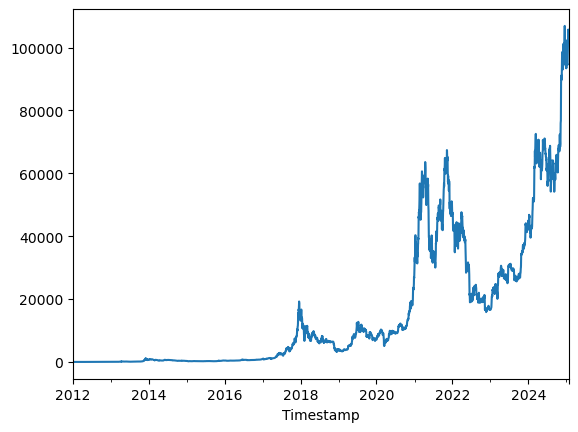

In [9]:
# Calcular la media por hora y rellenar posibles nulos
data_hour = train['Close'].resample('d').mean().ffill()

# Visualizamos la serie completa
data_hour.plot()
plt.show()

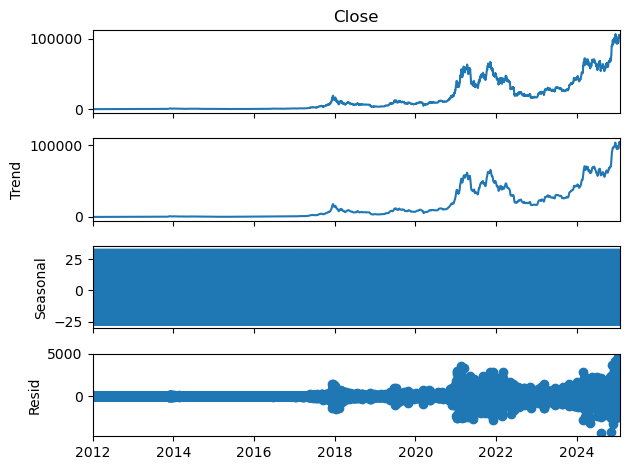

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Descomposición aditiva
resultado = seasonal_decompose(data_hour, model='additive')

# Representamos cada componente
resultado.plot()
plt.tight_layout()
plt.show()

In [11]:
print(data_hour)

Timestamp
2012-01-01         4.645697
2012-01-02         4.975000
2012-01-03         5.085500
2012-01-04         5.170396
2012-01-05         5.954361
                  ...      
2025-01-23    103613.000000
2025-01-24    105510.061061
2025-01-25    104711.000000
2025-01-26    104772.752753
2025-01-27    102514.000000
Freq: D, Name: Close, Length: 4776, dtype: float64


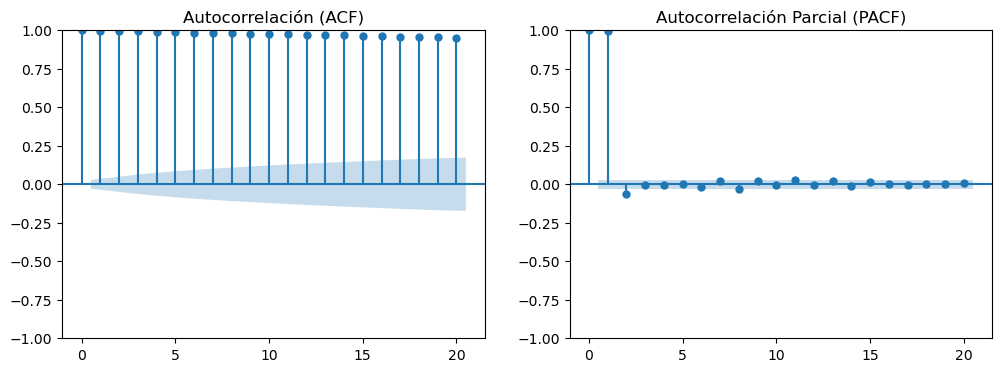

In [12]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(data_hour, lags=20, ax=ax[0])
ax[0].set_title("Autocorrelación (ACF)")

plot_pacf(data_hour, lags=20, ax=ax[1])
ax[1].set_title("Autocorrelación Parcial (PACF)")

plt.show()

In [13]:
# 1 año a considerar en el conjunto de test
n_steps = 365

# Dividimos la serie en train y test
train_size = len(data_hour) - n_steps
train, test = data_hour[:train_size], data_hour[train_size:]

# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(2, 2, 1))
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

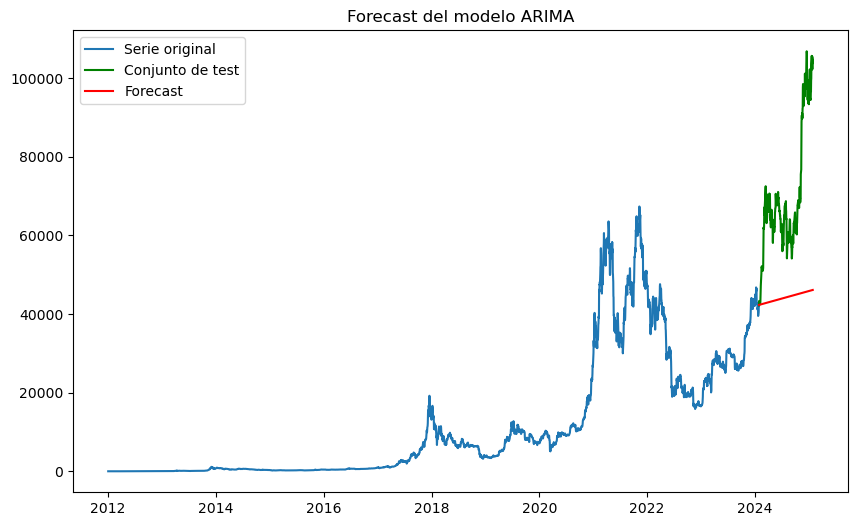

MAE: 25911.47
MAPE: 34.31%


In [14]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae  = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast) * 100
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

In [15]:
model = SARIMAX(train, order=(3, 1, 4), seasonal_order=(3, 1, 4, 7))
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

C:\Users\g3rm4\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


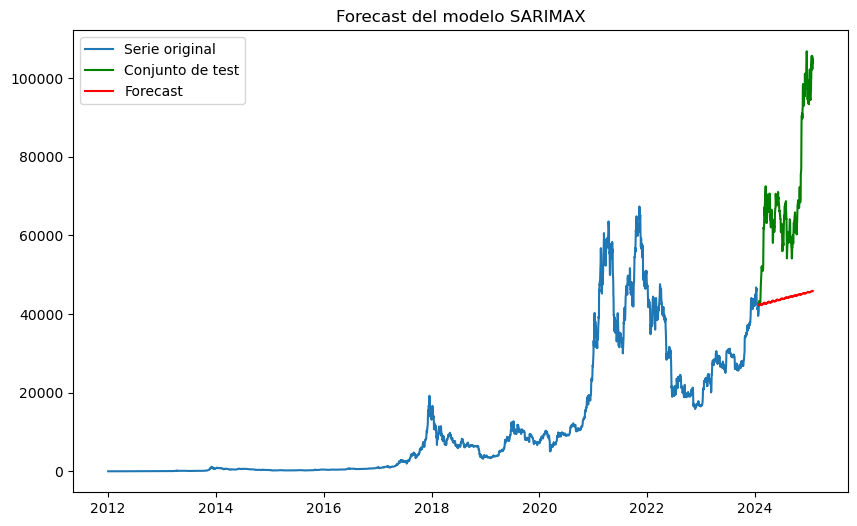

MAE: 26058.24
MAPE: 34.51%


In [16]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo SARIMAX')
plt.show()

# Evaluación del modelo
mae  = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast) * 100
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")